In [ ]:
!pip install openai
!pip install gplearn
import openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 337.0/337.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.0 MB/s eta 0:00:00


In [ ]:
import openai
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.datasets import make_regression
import gplearn.genetic as gp
import time
import sympy as sp
import os
import matplotlib.pyplot as plt

In [ ]:
%env OPENAI_API_KEY= None # to be added
openai.api_key = os.getenv("OPENAI_API_KEY")

In [ ]:
# Global variable for the model
MODEL = "gpt-4o"
GEN_TEMPERTURE = 0.0
ACC_TEMPERTURE = 0.0

Generating synthetic data...
Data generation completed.

Initializing our method...

Starting evaluation of both methods...

Evaluating traditional method...
Starting traditional symbolic regression...
Traditional symbolic regression completed in 143.39 seconds
Traditional method evaluation completed. MSE: 27.8888, R2: 0.9924
Time spent: 143.39 seconds

Evaluating our method...
Starting transformation process...
Neural network trained. Final loss: 0.4460
Model analysis completed.
Generated initial formula: y = 0.1514 * (0.1411 * (x1 + x2 + x3 + x4 + x5) + 0.2327) - 0.1259
Optimizing formula: y = 0.1514 * (0.1411 * (x1 + x2 + x3 + x4 + x5) + 0.2327) - 0.1259
Error: Unable to parse the formula: y = 0.1514 * (0.1411 * (x1 + x2 + x3 + x4 + x5) + 0.2327) - 0.1259
Optimized formula: a1*x1 + a2*x2 + a3*x3 + a4*x4 + a5*x5 + b
Formula evaluation - MSE: 3715.0493
Iteration 1, Current loss: 3715.0493
Optimizing formula: To improve the formula and potentially reduce the loss, we can introduce non-

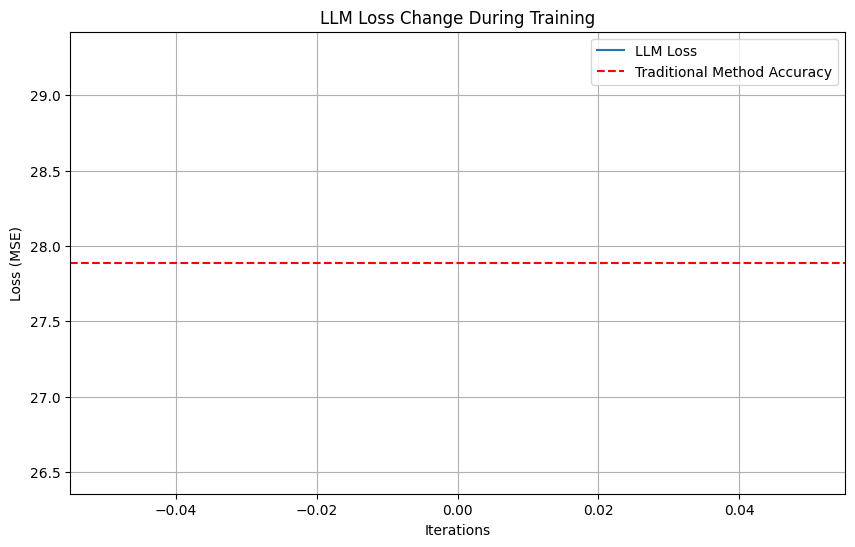

In [ ]:
class SymbolicRegressionTransformer:
    def __init__(self, input_dim, hidden_layers, output_dim, openai_api_key=openai.api_key, model=MODEL):
        self.model = self._build_model(input_dim, hidden_layers, output_dim)
        self.client = openai.OpenAI(api_key=openai_api_key)
        self.model_name = model
        self.conversation_history = []
        self.input_dim = input_dim
        self.iterations = 0
        self.time_spent = 0
        self.loss_history = []

    def _build_model(self, input_dim, hidden_layers, output_dim):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Input(shape=(input_dim,)))
        for units in hidden_layers:
            model.add(tf.keras.layers.Dense(units, activation='relu'))
        model.add(tf.keras.layers.Dense(output_dim))
        return model

    def train_model(self, X, y, epochs=100, batch_size=32):
        self.model.compile(optimizer='adam', loss='mse')
        history = self.model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=0)
        print(f"Neural network trained. Final loss: {history.history['loss'][-1]:.4f}")

    def analyze_model(self):
        analysis = "Model structure:\n"
        for i, layer in enumerate(self.model.layers):
            if i == 0:
                analysis += f"Input: {layer.input_shape[1]} features\n"
            else:
                analysis += f"Layer {i}: Dense({layer.units}, {layer.activation.__name__})\n"

        # Add information about weights
        for i, layer in enumerate(self.model.layers):
            if i > 0:  # Skip input layer
                weights, biases = layer.get_weights()
                analysis += f"Layer {i} weights shape: {weights.shape}, biases shape: {biases.shape}\n"
                analysis += f"Weight stats - Mean: {weights.mean():.4f}, Std: {weights.std():.4f}\n"
                analysis += f"Bias stats - Mean: {biases.mean():.4f}, Std: {biases.std():.4f}\n"

        self.log_conversation('system', f"Model analysis: {analysis}")
        print("Model analysis completed.")
        return analysis

    def generate_formula(self, model_analysis):
        prompt = f"""Based on the following neural network analysis, suggest a simple mathematical formula that could approximate its behavior. Use x1, x2, ..., x{self.input_dim} for input features. The formula should be a single line expression that can be parsed by a computer algebra system. Do not use any explanatory text, only return the formula. Do not use the max() function or any other complex functions, stick to basic arithmetic operations (+, -, *, /) and simple mathematical functions like exp() or log().

        {model_analysis}"""
        self.log_conversation('user', prompt)
        formula = self.generate()
        self.log_conversation('assistant', formula)
        print(f"Generated initial formula: {formula}")
        return formula.strip()

    def optimize_formula(self, formula, X, y, iterations=10):
        print(f"Optimizing formula: {formula}")
        try:
            expr = sp.sympify(formula)
        except sp.SympifyError:
            print(f"Error: Unable to parse the formula: {formula}")
            expr = sum(sp.Symbol(f'a{i}') * sp.Symbol(f'x{i}') for i in range(1, self.input_dim + 1)) + sp.Symbol('b')

        symbols = list(expr.free_symbols)
        params = [sym for sym in symbols if sym.name.startswith('a') or sym.name == 'b']
        variables = [sym for sym in symbols if sym not in params]

        if not params:
            params = [sp.Symbol(f'a{i}') for i in range(len(variables))] + [sp.Symbol('b')]
            expr = sum(param * var for param, var in zip(params[:-1], variables)) + params[-1]

        param_values = {param: np.random.uniform(-1, 1) for param in params}

        learning_rate = 0.01
        for _ in range(iterations):
            gradients = {param: 0 for param in params}
            for i in range(len(X)):
                x_values = {var: X[i][j] for j, var in enumerate(variables) if j < X.shape[1]}
                x_values.update(param_values)
                try:
                    pred = float(expr.evalf(subs=x_values))
                    error = pred - y[i]
                    for param in params:
                        grad = float(sp.diff(expr, param).evalf(subs=x_values))
                        gradients[param] += error * grad
                except (OverflowError, ValueError, TypeError):
                    continue

            for param in params:
                param_values[param] -= learning_rate * gradients[param] / len(X)

        optimized_formula = str(expr)
        print(f"Optimized formula: {optimized_formula}")
        return optimized_formula, param_values

    def iterate_formula(self, formula, param_values, X, y, iterations=5):
        for i in range(iterations):
            self.iterations += 1
            loss = self.evaluate_formula(formula, param_values, X, y)
            print(f"Iteration {i+1}, Current loss: {loss:.4f}")
            prompt = f"The current formula '{formula}' has a loss of {loss:.4f}. Suggest improvements to reduce this loss."
            self.log_conversation('user', prompt)
            improved_formula = self.generate()
            self.log_conversation('assistant', improved_formula)
            formula, param_values = self.optimize_formula(improved_formula, X, y)
        print(f"Final formula after {iterations} iterations: {formula}")
        return formula, param_values

    def evaluate_formula(self, formula, param_values, X, y):
        try:
            expr = sp.sympify(formula)
        except sp.SympifyError:
            print(f"Error: Unable to parse the formula: {formula}")
            return np.inf

        symbols = list(expr.free_symbols)
        variables = sorted([sym for sym in symbols if sym.name.startswith('x')], key=lambda sym: sym.name)

        if len(variables) > X.shape[1]:
            print(f"Error: Formula uses {len(variables)} variables, but input data has only {X.shape[1]} features")
            return np.inf

        y_pred = []
        for i in range(len(X)):
            x_values = {var: X[i][j] for j, var in enumerate(variables) if j < X.shape[1]}
            x_values.update(param_values)
            try:
                y_pred.append(float(expr.evalf(subs=x_values)))
            except (OverflowError, ValueError, TypeError):
                y_pred.append(np.nan)

        valid_indices = ~np.isnan(y_pred)
        y_pred_valid = np.array(y_pred)[valid_indices]
        y_valid = y[valid_indices]

        if len(y_pred_valid) > 0:
            mse = mean_squared_error(y_valid, y_pred_valid)
            print(f"Formula evaluation - MSE: {mse:.4f}")
            return mse
        else:
            print("Formula evaluation failed - all predictions were invalid")
            return np.inf

    def transform(self, X, y):
        start_time = time.time()
        print("Starting transformation process...")
        self.train_model(X, y)
        model_analysis = self.analyze_model()
        initial_formula = self.generate_formula(model_analysis)
        optimized_formula, param_values = self.optimize_formula(initial_formula, X, y)
        final_formula, final_param_values = self.iterate_formula(optimized_formula, param_values, X, y)
        self.time_spent = time.time() - start_time
        print(f"Transformation completed in {self.time_spent:.2f} seconds")
        return final_formula, final_param_values

    def log_conversation(self, role, content):
        self.conversation_history.append({'role': role, 'content': content})

    def generate(self):
        response = self.client.chat.completions.create(
            messages=self.conversation_history,
            model=self.model_name,
            temperature=0
        )
        generated_response = response.choices[0].message.content.strip()
        return generated_response

# Traditional Symbolic Regression (using gplearn as an example)
def traditional_symbolic_regression(X, y):
    print("Starting traditional symbolic regression...")
    start_time = time.time()
    est_gp = gp.SymbolicRegressor(population_size=5000, generations=20, stopping_criteria=0.01,
                                  p_crossover=0.7, p_subtree_mutation=0.1, p_hoist_mutation=0.05,
                                  p_point_mutation=0.1, max_samples=0.9, verbose=0,
                                  parsimony_coefficient=0.01, random_state=0)
    est_gp.fit(X, y)
    time_spent = time.time() - start_time
    print(f"Traditional symbolic regression completed in {time_spent:.2f} seconds")
    return est_gp, time_spent

def evaluate_methods(X_train, X_test, y_train, y_test, transformer, traditional_sr):
    print("\nEvaluating traditional method...")
    trad_sr, trad_time = traditional_sr(X_train, y_train)
    y_pred = trad_sr.predict(X_test)
    trad_mse = mean_squared_error(y_test, y_pred)
    trad_r2 = r2_score(y_test, y_pred)
    print(f"Traditional method evaluation completed. MSE: {trad_mse:.4f}, R2: {trad_r2:.4f}")
    print(f"Time spent: {trad_time:.2f} seconds")

    accuracy_goal = trad_mse

    print("\nEvaluating our method...")
    formula, param_values = transformer.transform(X_train, y_train)
    our_mse = transformer.evaluate_formula(formula, param_values, X_test, y_test)

    # Calculate R2 score
    expr = sp.sympify(formula)
    y_pred = []
    for row in X_test:
        x_values = {f'x{i+1}': x for i, x in enumerate(row)}
        x_values.update(param_values)
        y_pred.append(float(expr.evalf(subs=x_values)))
    our_r2 = r2_score(y_test, y_pred)

    print(f"Our method evaluation completed. MSE: {our_mse:.4f}, R2: {our_r2:.4f}")

    return our_mse, our_r2, transformer.time_spent, transformer.iterations, trad_mse, trad_r2, trad_time, accuracy_goal

# Main execution
if __name__ == "__main__":
    print("Generating synthetic data...")
    X, y = make_regression(n_samples=1000, n_features=5, noise=0.1, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print("Data generation completed.")

    print("\nInitializing our method...")
    transformer = SymbolicRegressionTransformer(input_dim=5, hidden_layers=[64, 32], output_dim=1)

    print("\nStarting evaluation of both methods...")
    our_mse, our_r2, our_time, our_iterations, trad_mse, trad_r2, trad_time, accuracy_goal = evaluate_methods(X_train, X_test, y_train, y_test, transformer, traditional_symbolic_regression)

    print("\nFinal Results:")
    print(f"Our method:")
    print(f"  MSE: {our_mse:.4f}")
    print(f"  R2 Score: {our_r2:.4f}")
    print(f"  Time spent: {our_time:.2f} seconds")
    print(f"  Iterations: {our_iterations}")

    print(f"\nTraditional Symbolic Regression:")
    print(f"  MSE: {trad_mse:.4f}")
    print(f"  R2 Score: {trad_r2:.4f}")
    print(f"  Time spent: {trad_time:.2f} seconds")

    # Plotting the loss change during training
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(transformer.loss_history) + 1), transformer.loss_history, label='LLM Loss')
    plt.axhline(y=accuracy_goal, color='r', linestyle='--', label='Traditional Method Accuracy')

    # Find the point where LLM surpasses traditional method
    surpass_index = next((i for i, loss in enumerate(transformer.loss_history) if loss < accuracy_goal), None)
    if surpass_index is not None:
        plt.axvline(x=surpass_index + 1, color='g', linestyle=':', label='Surpass Point')
        plt.text(surpass_index + 1.5, plt.ylim()[1], f'Time: {(surpass_index + 1) * (our_time / our_iterations):.2f}s', rotation=90, verticalalignment='top')

    plt.xlabel('Iterations')
    plt.ylabel('Loss (MSE)')
    plt.title('LLM Loss Change During Training')
    plt.legend()
    plt.grid(True)
    plt.show()